## CMA-ES for CartPole Torch (assignment version)
### Christian Igel, 2024

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

You may need the following packages:

``pip install gymnasium[classic-control]``

``python -m pip install cma``

In [24]:
import gymnasium as gym  # Defines RL environments

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)  # Set size of visualization
from IPython.display import clear_output  # For inline visualization

import torch
import torch.nn as nn
import torch.nn.functional as F

import cma

# Define task
env = gym.make('CartPole-v1')
state_space_dimension = env.observation_space.shape[0]
action_space_dimension = 1  # env.action_space.n - 1

Define the policy network:

In [ ]:
# Model definition
class PolicyNet(nn.Module):
    def __init__(self, use_bias=True):
        super(PolicyNet, self).__init__()
        self.hidden = nn.Linear(state_space_dimension, 5, bias=use_bias) # state_space_dimension = 4 for CartPole
        self.output = nn.Linear(5, 1, bias=use_bias)
        
    def forward(self, x):
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

policy_net = PolicyNet()

Compute number of parameters:

In [26]:
d = sum(
	param.numel() for param in policy_net.parameters()
)
print("Number of parameters:", d)

Number of parameters: 31


Helper function for visualization:

In [28]:
def visualize_policy(policy_net):
    env_render = gym.make('CartPole-v1', render_mode='rgb_array')
    state = env_render.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
    steps = 0
    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()
        print("step:", steps)
        if(terminated or truncated): 
            break
    env_render.close()
    return

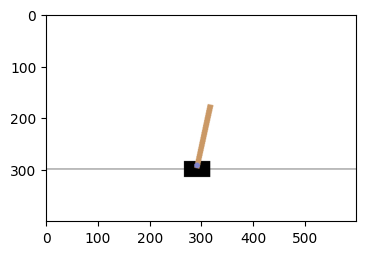

step: 8


In [29]:
visualize_policy(policy_net)

Now we define the objective/reward function. 
When the task is solved the functions returns -1000.
One successful trial is sufficient.

In [ ]:
def fitness_cart_pole(x, nn, env):
    '''
    Returns negative accumulated reward for single pole, fully environment.

    Parameters:
        x: Parameter vector encoding the weights.
        nn: Parameterized model.
        env: Environment ('CartPole-v?').
    '''
    torch.nn.utils.vector_to_parameters(torch.Tensor(x), nn.parameters())  # Set the policy parameters
    
    state = env.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, -1)) )
          
    R = 0  # accumulated reward
    while True:
        with torch.no_grad():
            action = int(policy_net(state_tensor) > 0)
        state, reward, terminated, truncated, _ = env.step(action)
        state_tensor = torch.Tensor(state.reshape(1, -1))
        R += reward
        
        if terminated or truncated:
            return -1000 if truncated else -R  

In [31]:
def test_policy(policy_net, num_tests=20):
    total_steps = 0
    for _ in range(num_tests):
        env = gym.make('CartPole-v1')
        state = env.reset()
        state_tensor = torch.Tensor(state[0].reshape(1, -1))
        steps = 0
        
        while True:
            with torch.no_grad():
                action = int(policy_net(state_tensor) > 0)
            state, _, terminated, truncated, _ = env.step(action)
            state_tensor = torch.Tensor(state.reshape(1, -1))
            steps += 1
            
            if terminated or truncated:
                break
                
        total_steps += steps
        env.close()
        
    return total_steps / num_tests


Do the learning:

In [33]:
initial_weights = np.random.normal(0, 0.01, d)  # random parameters for initial policy, d denotes the number of weights
initial_sigma = .01 # initial global step-size sigma

res = cma.fmin(fitness_cart_pole,  
               initial_weights,
               initial_sigma,
               args=([policy_net, env]),
               options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
env.close()

# set the policy parameters to the final solution
torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), policy_net.parameters())  

print("best solution found after", res[2], "evaluations")

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 31 (seed=694697, Wed Feb 26 21:06:02 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.000000000000000e+01 1.0e+00 9.36e-03  9e-03  9e-03 0:00.0
    2     28 -1.100000000000000e+01 1.1e+00 9.11e-03  9e-03  9e-03 0:00.1
    3     42 -1.000000000000000e+01 1.1e+00 8.91e-03  9e-03  9e-03 0:00.2
   38    532 -5.800000000000000e+01 1.4e+00 5.58e-03  5e-03  6e-03 0:03.3
   70    980 -3.300000000000000e+01 1.8e+00 4.03e-03  3e-03  4e-03 0:07.4
   94   1316 -1.000000000000000e+03 2.1e+00 4.39e-03  3e-03  5e-03 0:11.4
termination on ftarget=-999.9 (Wed Feb 26 21:06:15 2025)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 1316/1304 evaluations
incumbent solution: [-0.01034761 -0.02867698 -0.0055262  -0.00457515 -0.01609384  0.06311634
 -0.01440027 -0.00146451 ...]
std deviations: [0.00417051 0.00449173 0.00407091 0.00441887 0.00444994 0.00437828
 0.0045176  0.00436237 ...]
best solution found 

Render solution:

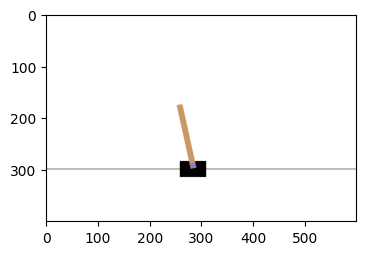

step: 81


In [34]:
visualize_policy(policy_net)

In [46]:
from collections import defaultdict

def run_experiments(num_trials=10):
    results = defaultdict(list)
    
    for use_bias in [True, False]:
        print(f"\nRunning experiments {'WITH' if use_bias else 'WITHOUT'} bias...")
        
        for trial in range(num_trials):
            # init policy and environment
            policy_net = PolicyNet(use_bias=use_bias)
            env = gym.make('CartPole-v1')
            
            # CMA-ES setup
            d = sum(p.numel() for p in policy_net.parameters())
            initial_weights = np.random.normal(0, 0.01, d)
            
            # run CMA-ES optimization
            res = cma.fmin(
                lambda x: fitness_cart_pole(x, policy_net, env),
                initial_weights,
                0.01,
                options={'ftarget': -999.9, 'maxiter': 100, 'verbose': -1}
            )
            
            # record results
            evaluations = res[1]
            test_perf = test_policy(policy_net)
            
            results['with_bias' if use_bias else 'without_bias'].append({
                'evaluations': evaluations,
                'test_performance': test_perf
            })
            
            env.close()
            print(f"Trial {trial+1}: {evaluations} evals, Test perf: {test_perf:.1f} steps")

    # calculate averages
    summary = {}
    for arch in ['with_bias', 'without_bias']:
        evals = [t['evaluations'] for t in results[arch]]
        perfs = [t['test_performance'] for t in results[arch]]
        summary[arch] = {
            'avg_evals': np.mean(evals),
            'std_evals': np.std(evals),
            'avg_perf': np.mean(perfs),
            'std_perf': np.std(perfs)
        }
    
    return summary

In [45]:
if __name__ == "__main__":
    results = run_experiments(num_trials=10)
    
    print("\nFinal Results:")
    for arch in ['with_bias', 'without_bias']:
        data = results[arch]
        print(f"\n{arch.upper().replace('_', ' ')}:")
        print(f"Average evaluations to solve: {data['avg_evals']:.1f} ± {data['std_evals']:.1f}")
        print(f"Average test performance: {data['avg_perf']:.1f} ± {data['std_perf']:.1f} steps")


Running experiments WITH bias...
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.500000000000000e+01 1.0e+00 9.47e-03  9e-03  1e-02 0:00.0


    2     28 -2.600000000000000e+01 1.1e+00 9.07e-03  9e-03  9e-03 0:00.1
    3     42 -6.500000000000000e+01 1.1e+00 8.63e-03  9e-03  9e-03 0:00.2
   43    602 -3.100000000000000e+01 1.5e+00 6.45e-03  6e-03  7e-03 0:03.2
   68    952 -1.460000000000000e+02 2.0e+00 4.96e-03  4e-03  5e-03 0:07.4
   90   1260 -1.090000000000000e+02 2.3e+00 4.60e-03  3e-03  5e-03 0:12.6
  100   1400 -1.100000000000000e+02 2.6e+00 4.64e-03  3e-03  5e-03 0:15.1
termination on maxiter=100 (Wed Feb 26 21:27:59 2025)
final/bestever f-value = -7.800000e+01 -1.640000e+02 after 1401/1114 evaluations
incumbent solution: [-0.06507652 -0.01935656 -0.00038601 -0.08828406 -0.01574105  0.00069226
 -0.01731921  0.00787646 ...]
std deviations: [0.00444415 0.00443289 0.00439916 0.00478261 0.00428152 0.00466818
 0.00458606 0.00463943 ...]


AttributeError: 'float' object has no attribute 'evals'

Learn more about CMA-ES optimization:

In [ ]:
# Visualize the optimization 
#cma.plot();  

In [ ]:
# Learn even more on CMA-ES
#cma.CMAOptions() 